# AIT Deep Learning Pedestrian Detection Project

Note: We used GitHub Copilot to generate some of the code, such as displaying images using matplotlib.

### 1-1: Load Images and annotations.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO
import numpy as np
import pylab
import random
import pickle as pk
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

2024-04-13 17:29:30.256699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 17:29:30.256724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 17:29:30.257055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 17:29:30.261025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# We are using their validation images for testing, as they don't provide a test annotation.
train_anno = 'annotations/dhd_pedestrian_traffic_train.json'
test_anno = 'annotations/dhd_pedestrian_traffic_val.json' 

train_image_dir = "images/train/"
test_image_dir = "images/val/"

coco_train = COCO(train_anno)
coco_test = COCO(test_anno)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [3]:
def get_coco_and_dir(img_type):
    '''
    Return the corresponding coco, and image dir based on image type (train, test)
    '''
    if img_type in ("train", "valid"):
        return coco_train, train_image_dir
    elif img_type == "test":
        return coco_test, test_image_dir
    else:
        raise ValueError("Unknown image type")

### Load an example image and annotation.

In [4]:
len(coco_train.getImgIds())

13858

In [5]:
# Displaying image with annotation
def show_image(img_type, image_id, image_path, show_anns=True):
    coco, _ = get_coco_and_dir(img_type)
    
    plt.axis('off')
    image = mpimg.imread(image_path)
    plt.imshow(image)
    if show_anns:
        annIds = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(annIds)
        print("There are", len(annIds), "pedestrians")
        coco.showAnns(anns)

There are 6 pedestrians


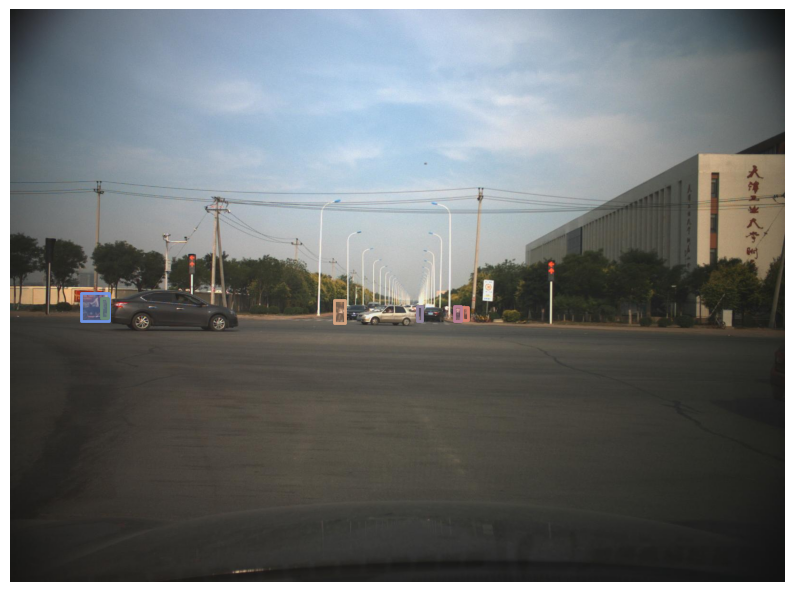

In [6]:
image_id = coco_train.getImgIds()[9]
image_path = train_image_dir + coco_train.loadImgs(image_id)[0]['file_name']
show_image("train", image_id, image_path)

### 1-2 Process Training, Validation, and Test dataset

In [7]:
train_rate = 0.8

train_valid_imgIds = coco_train.getImgIds()
random.shuffle(train_valid_imgIds)

train_imgIds = train_valid_imgIds[:int(train_rate * len(train_valid_imgIds))]
valid_imgIds = train_valid_imgIds[int(train_rate * len(train_valid_imgIds)):]
test_imgIds = coco_test.getImgIds()

print("Number of pictures in the train data     :", len(train_imgIds))
print("Number of pictures in the validation data:", len(valid_imgIds))
print("Number of pictures in the test data      :", len(test_imgIds))

Number of pictures in the train data     : 11086
Number of pictures in the validation data: 2772
Number of pictures in the test data      : 2136


However, we do not intend to use all of the available data. Thus, we will took a sample from training, valid, and test data.

In the end, we aim for 5000 training, 500 valid, and 1000 test data.

In [8]:
sample_train_imgIds = random.sample(train_imgIds, k = 5000)
sample_valid_imgIds = random.sample(valid_imgIds, k = 500)
sample_test_imgIds = random.sample(test_imgIds, k = 1000)

In [9]:
def get_pedestrian_count(coco, img_type, image_id):
    '''
    Get number of pedestrian in a picture.
    '''
    annIds = coco.getAnnIds(imgIds=image_id)
    return len(annIds)  

def load_and_process_image(img_type, image_id):
    '''
    Load an Image, resize image to (244, 244) and apply VGG16 preprocess method.
    '''
    coco, image_dir = get_coco_and_dir(img_type)
    
    img = coco.loadImgs(image_id)[0]
    img_path = image_dir + img['file_name']
    img = image_utils.load_img(img_path, target_size=(224, 224))
    img = image_utils.img_to_array(img, dtype="float32")
    img = preprocess_input(img) # VGG16 preprocessing

    # Get number of pedestrians in the image
    num_pedestrians = get_pedestrian_count(coco, img_type, image_id)

    return img, num_pedestrians

In [10]:
def load_and_process_images(img_type, imgIds):
    '''
    Load and process a list of Images
    '''
    print(f"Processing {img_type} data.")
    images = np.zeros((len(imgIds), 224, 224, 3), dtype=np.float32)
    pedestrian_counts = []
    total_images = len(imgIds)
    progress_interval = total_images // 10  # 10% progress interval
    
    for i, imgId in enumerate(imgIds):
        img, num_pedestrians = load_and_process_image(img_type, imgId)
        images[i] = img
        pedestrian_counts.append(num_pedestrians)
        
        if (i + 1) % progress_interval == 0:
            progress = round((i + 1) / total_images * 10)
            print(f"[{'*' * progress}{'.' * (10-progress)}]")
    
    return images, np.array(pedestrian_counts)

In [11]:
X_train, Y_train = load_and_process_images("train", train_imgIds)

Processing train data.
[*.........]
[**........]
[***.......]
[****......]
[*****.....]
[******....]
[*******...]
[********..]
[*********.]
[**********]


(array([2795., 2681., 1892., 1296.,  869.,  538.,  374.,  228.,  143.,
          83.,   64.,   35.,   35.,   26.,    8.,    6.,    5.,    4.,
           4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

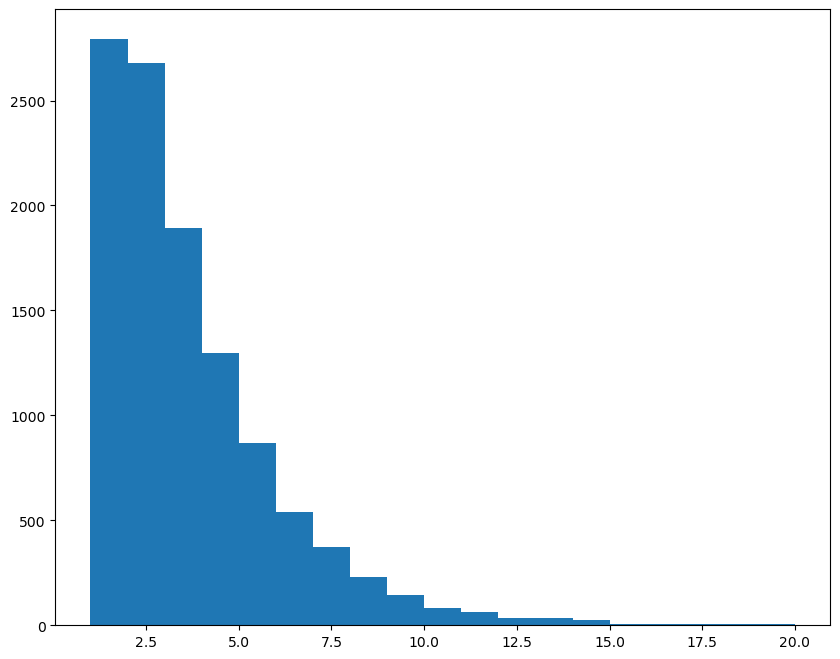

In [12]:
plt.hist(Y_train, bins=np.unique(Y_train))

In [11]:
X_train, Y_train = load_and_process_images("train", sample_train_imgIds)
X_valid, Y_valid = load_and_process_images("valid", sample_valid_imgIds)
X_test, Y_test = load_and_process_images("test", sample_test_imgIds)

processed_data = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_valid": X_valid,
    "Y_valid": Y_valid,
    "X_test": X_test,
    "Y_test": Y_test,
}


Processing train data.
[*.........]
[**........]
[***.......]
[****......]
[*****.....]
[******....]
[*******...]
[********..]
[*********.]
[**********]
Processing valid data.
[*.........]
[**........]
[***.......]
[****......]
[*****.....]
[******....]
[*******...]
[********..]
[*********.]
[**********]
Processing test data.
[*.........]
[**........]
[***.......]
[****......]
[*****.....]
[******....]
[*******...]
[********..]
[*********.]
[**********]


In [12]:
# Exporting the processed data to a pickle file
# with open("./processed_data/data.pickle", "wb") as f:
#     pk.dump(processed_data, f)

In [13]:
# Importing the exported data containg X and Y values
# with open("./processed_data/data.pickle", "rb") as f:
#     processed_data = pk.load(f)

In [19]:
def sample_data_equal(X, Y, n=30):
    cnt = {y: 0 for y in np.unique(Y)}
    existed = set()
    idx_pop = range(len(X))
    res_idx = []

    for _ in range(len(X) * len(X)):
        idx = random.choice(idx_pop)

        if idx in existed:
            continue
        existed.add(idx)

        if cnt[Y[idx]] < n:
            res_idx.append(idx)
            cnt[Y[idx]] += 1

    return X[res_idx], Y[res_idx]

In [20]:
X_t, Y_t = sample_data_equal(X_train, Y_train, 500)

In [22]:
Y_t.shape

(4015,)

(array([500., 500., 500., 500., 500., 500., 374., 228., 143.,  83.,  64.,
         35.,  35.,  26.,   8.,   6.,   5.,   4.,   4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

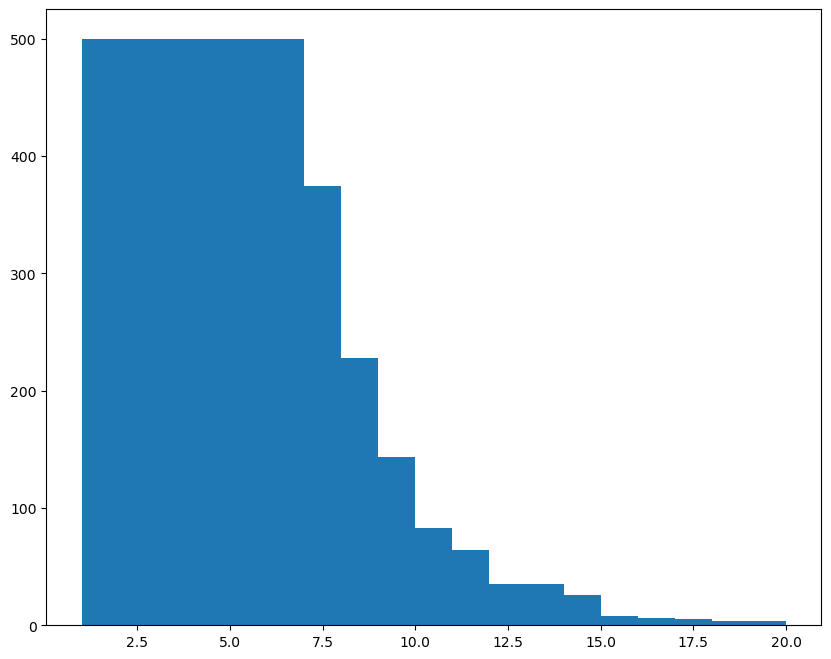

In [21]:
plt.hist(Y_t, bins=np.unique(Y_t))

In [23]:
processed_data = {
    "X_train": X_t,
    "Y_train": Y_t
}
# Exporting the processed data to a pickle file
with open("./processed_data/training_data.pickle", "wb") as f:
    pk.dump(processed_data, f)